## Neural Machine Translation


In [ ]:
!nvidia-smi

Tue May 10 16:36:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Data taken from YSDA NLP course
!wget -nc https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt

File ‘data.txt’ already there; not retrieving.



The `data.txt` is a tsv file, each line of which contains a sentence in english and a corresponding translation, separated by `\t`. We'll load it into memory and create a list of pairs, which would yield the same interface as with the torchtext's datasets.

In [ ]:
with open("data.txt") as f:
    data = [l.rstrip().split("\t") for l in f]

print(f"Dataset size {len(data):,}")
print("Sample:")
data[:5]

Dataset size 50,000
Sample:


[['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.',
  'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.'],
 ['At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.',
  'В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.'],
 ['Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.',
  'Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.'],
 ['Each has a TV and a private bathroom with shower.',
  'В вашем распоряжении также телевизор и собственная ванная комната с душем.'],
 ['Your room comes with air conditioning and satellite TV.',
  'Номер оснащен кондиционером и спутниковым телевидением.']]

## Data preprocessing

Splitting our dataset into train, test and validation.

In [ ]:
import torch
from torch.utils.data import random_split


data_size = len(data)
train_size = int(0.8 * data_size)
test_size = int(0.15 * data_size)
val_size = data_size - train_size - test_size
train_data, test_data, val_data = random_split(
    data, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42)
)
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Val size: {len(val_data)}")

Train size: 40000
Test size: 7500
Val size: 2500


In [ ]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()


def tokenize(sent):
    return tokenizer.tokenize(sent.lower())

In [ ]:

from collections import Counter

from torchtext.vocab import vocab as Vocab


src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=3)
trg_vocab = Vocab(trg_counter, min_freq=3)

In [ ]:
unk_token = "<unk>"
sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token]

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=0)
        vocab.set_default_index(0)

    for token in specials:
        if token not in vocab:
            vocab.append_token(token)

print(f"Source (en) vocabulary size: {len(src_vocab)}")
print(f"Target (ru) vocabulary size: {len(trg_vocab)}")

Source (en) vocabulary size: 6711
Target (ru) vocabulary size: 9310


In [ ]:
def encode(sent, vocab):
    tokenized = [sos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        src_encoded = encode(src, src_vocab)
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = encode(trg, trg_vocab)
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])
    return src_padded, trg_padded


batch_size = 100
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate_batch)

src_batch, trg_batch = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape

(torch.Size([39, 100]), torch.Size([36, 100]))

## Model side

In [ ]:
import random

import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        _, hidden = self.rnn(embedded)
        return hidden


class Decoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, n_tokens)

    def forward(self, input, hidden):
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        output, hidden = self.rnn(embedded, hidden)
        pred = self.out(output.squeeze(dim=0))
        return pred, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.hid_dim == decoder.hid_dim, "encoder and decoder must have same hidden dim"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "encoder and decoder must have equal number of layers"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        hidden = self.encoder(src)

        # First input to the decoder is the <sos> token.
        input = trg[0, :]
        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
enc = Encoder(len(src_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)
dec = Decoder(len(trg_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)
model = Seq2Seq(enc, dec).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model.apply(init_weights);

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 16,233,822 trainable parameters


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])
loss_history, train_loss_history, val_loss_history = [], [], []

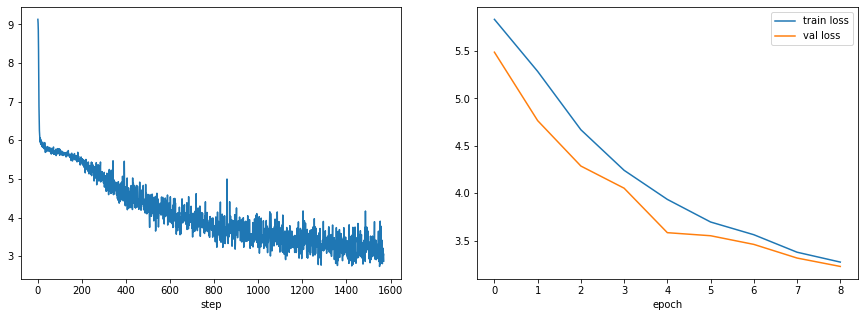

Number of epoches: 10
Training time:  636.8011515140533 seconds 


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
import time

start_time = time.time()


n_epochs = 10
clip = 1
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for src, trg in train_dataloader:
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg)

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()
        loss_history.append(loss.item())

        if len(loss_history) % 10 == 0:
            clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(121)
            plt.plot(loss_history)
            plt.xlabel("step")

            plt.subplot(122)
            plt.plot(train_loss_history, label="train loss")
            plt.plot(val_loss_history, label="val loss")
            plt.xlabel("epoch")
            plt.legend()

            plt.show()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg in val_dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_loss_history.append(val_loss)

print("Number of epoches: %s" % n_epochs)
print("Training time:  %s seconds " % (time.time() - start_time))

## Model evaluation

In [ ]:
trg_itos = trg_vocab.get_itos()
model.eval()
max_len = 50
with torch.no_grad():
    for i, (src, trg) in enumerate(val_data):
        encoded = encode(src, src_vocab)[::-1]
        encoded = torch.tensor(encoded)[:, None].to(device)
        hidden = model.encoder(encoded)

        pred_tokens = [trg_vocab[sos_token]]
        for _ in range(max_len):
            decoder_input = torch.tensor([pred_tokens[-1]]).to(device)
            pred, hidden = model.decoder(decoder_input, hidden)
            _, pred_token = pred.max(dim=1)
            if pred_token == trg_vocab[eos_token]:
                break

            pred_tokens.append(pred_token.item())

        print(f"src: '{src.rstrip().lower()}'")
        print(f"trg: '{trg.rstrip().lower()}'")
        print(f"pred: '{' '.join(trg_itos[i] for i in pred_tokens[1:])}'")
        print()

        if i == 10:
            break

src: 'all apartments have a dvd player and satellite tv, a kitchen with a microwave, and a washing machine and a tumble dryer.'
trg: 'все они оснащены телевизором со спутниковыми каналами и dvd-плеером, а также располагают кухней с микроволновой печью и стиральной/сушильной машиной.'
pred: 'в распоряжении гостей мини - кухня с духовкой , микроволновой печью , холодильником , а также , , , , , и и и .'

src: 'they are fitted with blackout curtains, free drinking water and free toiletries.'
trg: 'гостям предоставляется бесплатная питьевая вода и бесплатные туалетно-косметическими принадлежности.'
pred: 'во всех номерах есть <unk> , , холодильник , письменный стол и постельное белье .'

src: 'a small refrigerator, coffee-making facilities and a work desk are included.'
trg: 'к услугам гостей также небольшой холодильник, принадлежности для кофе и рабочий стол.'
pred: 'в числе удобств — , , , , , , , , и гладильные принадлежности .'

src: 'only 250 metres away, paral•lel metro station offer

The metric used for evaluation will be BLEU.
Here is how it is calculated:

In [ ]:
from nltk.translate.bleu_score import corpus_bleu


references, hypotheses = [], []
with torch.no_grad():
    for src, trg in test_dataloader:
        output = model(src.to(device), trg.to(device), teacher_forcing_ratio=0)
        output = output.cpu().numpy().argmax(axis=2)

        for i in range(trg.shape[1]):
            reference = trg[:, i]
            reference_tokens = [trg_itos[id_] for id_ in reference]
            reference_tokens = [tok for tok in reference_tokens if tok not in specials]
            references.append(reference_tokens)

            hypothesis = output[:, i]
            hypothesis_tokens = [trg_itos[id_] for id_ in hypothesis]
            hypothesis_tokens = [tok for tok in hypothesis_tokens if tok not in specials]
            hypotheses.append(hypothesis_tokens)

# corpus_bleu works with multiple references
bleu = corpus_bleu([[ref] for ref in references], hypotheses)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")

Your model shows test BLEU of 11.9


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Bidirectional LSTM

**Let's first try some simple enhancements: use bidirectional LSTM encoder and increase number of LSTM layers in encoder and decoder.**

In [ ]:
import random

import torch.nn as nn


class BidirectionalLSTMEncoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=True)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        _, hidden = self.rnn(embedded)
        batch_size = src.shape[-1]
        return (hidden[0].permute(1,0,2).reshape(batch_size, self.n_layers, -1).permute(1,0,2).contiguous(), 
                hidden[1].permute(1,0,2).reshape(batch_size, self.n_layers, -1).permute(1,0,2).contiguous())


class BidirectionalDecoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        decoder_hid_dim = hid_dim * 2
        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, decoder_hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(decoder_hid_dim, n_tokens)

    def forward(self, input, hidden):
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        output, hidden = self.rnn(embedded, hidden)
        pred = self.out(output.squeeze(dim=0))
        return pred, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.hid_dim == decoder.hid_dim, "encoder and decoder must have same hidden dim"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "encoder and decoder must have equal number of layers"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        hidden = self.encoder(src)

        # First input to the decoder is the <sos> token.
        input = trg[0, :]
        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
enc = BidirectionalLSTMEncoder(len(src_vocab), emb_dim=256, hid_dim=512, n_layers=4, dropout=0.5)
dec = BidirectionalDecoder(len(trg_vocab), emb_dim=256, hid_dim=512, n_layers=4, dropout=0.5)
model = Seq2Seq(enc, dec).to(device)
model.apply(init_weights);
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 66,138,462 trainable parameters


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])
loss_history, train_loss_history, val_loss_history = [], [], []

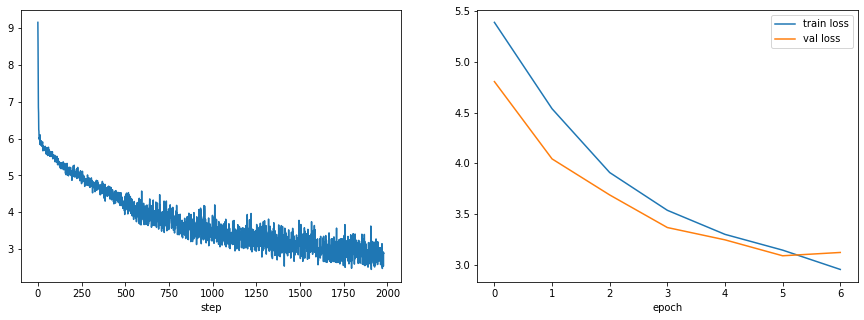

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
import time

start_time = time.time()


n_epochs = 10
clip = 1
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for src, trg in train_dataloader:
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg)

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()
        loss_history.append(loss.item())

        if len(loss_history) % 10 == 0:
            clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(121)
            plt.plot(loss_history)
            plt.xlabel("step")

            plt.subplot(122)
            plt.plot(train_loss_history, label="train loss")
            plt.plot(val_loss_history, label="val loss")
            plt.xlabel("epoch")
            plt.legend()

            plt.show()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg in val_dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_loss_history.append(val_loss)

print("Number of epoches: %s" % n_epochs)
print("Training and validation time:  %s seconds " % (time.time() - start_time))

**Validation loss started increasing and I stopped training at this point. \
It took the model about 35 mins to train and validate on 6 epoches. It is much slower than the baseline model.**

### Evaluation

In [ ]:
trg_itos = trg_vocab.get_itos()
model.eval()
max_len = 50
with torch.no_grad():
    for i, (src, trg) in enumerate(val_data):
        encoded = encode(src, src_vocab)[::-1]
        encoded = torch.tensor(encoded)[:, None].to(device)
        hidden = model.encoder(encoded)

        pred_tokens = [trg_vocab[sos_token]]
        for _ in range(max_len):
            decoder_input = torch.tensor([pred_tokens[-1]]).to(device)
            pred, hidden = model.decoder(decoder_input, hidden)
            _, pred_token = pred.max(dim=1)
            if pred_token == trg_vocab[eos_token]:
                break

            pred_tokens.append(pred_token.item())

        print(f"src: '{src.rstrip().lower()}'")
        print(f"trg: '{trg.rstrip().lower()}'")
        print(f"pred: '{' '.join(trg_itos[i] for i in pred_tokens[1:])}'")
        print()

        if i == 5:
            break

src: 'all apartments have a dvd player and satellite tv, a kitchen with a microwave, and a washing machine and a tumble dryer.'
trg: 'все они оснащены телевизором со спутниковыми каналами и dvd-плеером, а также располагают кухней с микроволновой печью и стиральной/сушильной машиной.'
pred: 'в числе удобств удобств стиральная машина , стиральная машина , стиральная машина , стиральная машина , телевизор с плоским экраном и кабельными каналами .'

src: 'they are fitted with blackout curtains, free drinking water and free toiletries.'
trg: 'гостям предоставляется бесплатная питьевая вода и бесплатные туалетно-косметическими принадлежности.'
pred: 'гостям предоставляются бесплатные туалетно - косметические принадлежности и <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> .'

src: 'a small refrigerator, coffee-making facilities and a work desk are included.'
trg: 'к услугам гостей также небольшой холодильник, принадлежности для кофе и рабочий стол.'
pred: 'гости могут пользоваться обще

In [ ]:
from nltk.translate.bleu_score import corpus_bleu


references, hypotheses = [], []
with torch.no_grad():
    for src, trg in test_dataloader:
        output = model(src.to(device), trg.to(device), teacher_forcing_ratio=0)
        output = output.cpu().numpy().argmax(axis=2)

        for i in range(trg.shape[1]):
            reference = trg[:, i]
            reference_tokens = [trg_itos[id_] for id_ in reference]
            reference_tokens = [tok for tok in reference_tokens if tok not in specials]
            references.append(reference_tokens)

            hypothesis = output[:, i]
            hypothesis_tokens = [trg_itos[id_] for id_ in hypothesis]
            hypothesis_tokens = [tok for tok in hypothesis_tokens if tok not in specials]
            hypotheses.append(hypothesis_tokens)

# corpus_bleu works with multiple references
bleu = corpus_bleu([[ref] for ref in references], hypotheses)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")

Your model shows test BLEU of 17.5


**We can notice a significant increase in scores**

# Attention

**Now we'll apply Attention from decoder to encoder to the previous model.**

In [ ]:
import random

import torch.nn as nn


class BidirectionalAttantionEncoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=True)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        output, hidden = self.rnn(embedded)
        batch_size = src.shape[-1]
        return output, (hidden[0].permute(1,0,2).reshape(batch_size, self.n_layers, -1).permute(1,0,2).contiguous(), 
                        hidden[1].permute(1,0,2).reshape(batch_size, self.n_layers, -1).permute(1,0,2).contiguous())


class BidirectionalAttentionDecoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout, n_attn_heads):
        super().__init__()
        decoder_hid_dim = hid_dim * 2
        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, decoder_hid_dim, n_layers, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=decoder_hid_dim, num_heads=n_attn_heads, dropout=dropout)
        self.change_dim = nn.Linear(n_layers * decoder_hid_dim, decoder_hid_dim)
        self.out = nn.Linear(decoder_hid_dim * 2, n_tokens)

    def forward(self, input, hidden, encoder_output):
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        output, (hidden, cell) = self.rnn(embedded, hidden)
        batch_size = output.shape[1]
        attn_hidden = (self.change_dim(hidden.permute(1,0,2).reshape(batch_size, 1, -1))).permute(1,0,2)
        context, _ = self.attention(attn_hidden, encoder_output, encoder_output, need_weights=False)

        pred = self.out(torch.cat((output.squeeze(dim=0), context.squeeze(dim=0)), dim=-1))
        return pred, (hidden, cell)

class AttentionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.hid_dim == decoder.hid_dim, "encoder and decoder must have same hidden dim"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "encoder and decoder must have equal number of layers"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        encoder_output, hidden = self.encoder(src)

        # First input to the decoder is the <sos> token.
        input = trg[0, :]
        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, hidden, encoder_output)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
enc = BidirectionalAttantionEncoder(len(src_vocab), emb_dim=256, hid_dim=512, n_layers=3, dropout=0.5)
dec = BidirectionalAttentionDecoder(len(trg_vocab), emb_dim=256, hid_dim=512, n_layers=3, dropout=0.5, n_attn_heads=8)
model = AttentionSeq2Seq(enc, dec).to(device)
model.apply(init_weights);
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 68,320,606 trainable parameters


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])
loss_history, train_loss_history, val_loss_history = [], [], []

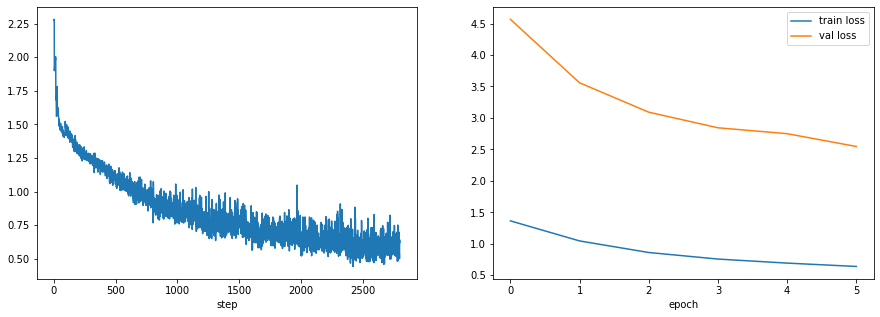

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
import time

start_time = time.time()

n_epochs = 50
clip = 1
steps_to_wait = 4
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    train_loss = 0
    for i, (src, trg) in enumerate(train_dataloader):
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg)

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss /= steps_to_wait
        loss.backward()

        clip_grad_norm_(model.parameters(), clip)

        if (i + 1) % steps_to_wait == 0:
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.item()
        loss_history.append(loss.item())

        if len(loss_history) % 10 == 0:
            clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(121)
            plt.plot(loss_history)
            plt.xlabel("step")

            plt.subplot(122)
            plt.plot(train_loss_history, label="train loss")
            plt.plot(val_loss_history, label="val loss")
            plt.xlabel("epoch")
            plt.legend()

            plt.show()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg in val_dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_loss_history.append(val_loss)

print("Number of epoches: %s" % n_epochs)
print("Training and validation time:  %s seconds " % (time.time() - start_time))

In [ ]:
from nltk.translate.bleu_score import corpus_bleu


references, hypotheses = [], []
with torch.no_grad():
    for src, trg in test_dataloader:
        output = model(src.to(device), trg.to(device), teacher_forcing_ratio=0)
        output = output.cpu().numpy().argmax(axis=2)

        for i in range(trg.shape[1]):
            reference = trg[:, i]
            reference_tokens = [trg_itos[id_] for id_ in reference]
            reference_tokens = [tok for tok in reference_tokens if tok not in specials]
            references.append(reference_tokens)

            hypothesis = output[:, i]
            hypothesis_tokens = [trg_itos[id_] for id_ in hypothesis]
            hypothesis_tokens = [tok for tok in hypothesis_tokens if tok not in specials]
            hypotheses.append(hypothesis_tokens)

# corpus_bleu works with multiple references
bleu = corpus_bleu([[ref] for ref in references], hypotheses)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")